In [ ]:
# default_exp interpret

In [ ]:
# hide
import sys

sys.path.append("..")

# Interpret

> Interpret the results of a model

In [ ]:
# export
from fastseq.all import *
from fastseq.data.external import *
from fastai2.basics import *
from fastseq.models.nbeats import *

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Need to pad 100/100 time series due to length.
Train:100; Valid: 600; Test 100


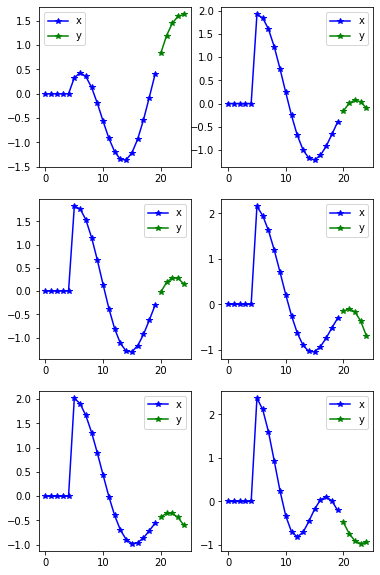

In [ ]:
items = dummy_data_generator(25,10, nrows=100)
dbunch = TSDataBunch.from_items(items, horizon = 5)
dbunch.show_batch(max_n=6)

In [ ]:
learn = nbeats_learner(dbunch)
print(learn.model)
print(learn.summary())

NBeatsNet(
  (stacks): Sequential(
    (trend0): Sequential(
      (0): TrendBlock(
        (layers): Sequential(
          (0): LinBnDrop(
            (0): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Linear(in_features=20, out_features=200, bias=False)
            (2): ReLU(inplace=True)
          )
          (1): LinBnDrop(
            (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Linear(in_features=200, out_features=100, bias=False)
          )
        )
        (theta_b_fc): LinBnDrop(
          (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): Linear(in_features=100, out_features=2, bias=False)
        )
        (theta_f_fc): LinBnDrop(
          (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): Linear(in_features=100, out_features=2, bias=False)
        )
      )
      (1

In [ ]:
learn.lr_find()

RuntimeError: running_mean should contain 192 elements not 160

In [ ]:
learn.fit(1, .1)

epoch,train_loss,valid_loss,mae,time
0,198.957916,199.994339,30784.589844,00:01


In [ ]:
learn.show_results(max_n=9)

RuntimeError: shape '[64, -1]' is invalid for input of size 1

In [ ]:
learn.get_preds(dl=learn.dbunch.dls[1], with_input=True, with_loss=True, with_decoded=True, act=None)

RuntimeError: shape '[96, -1]' is invalid for input of size 1

In [ ]:
learn.get_preds(dl=learn.dbunch.dls[1], with_input=True, with_loss=True, with_decoded=True, act=None)

RuntimeError: shape '[96, -1]' is invalid for input of size 1

In [ ]:
#hide
class _Interpretation():
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, dl, inputs, preds, targs, decoded, losses):
        store_attr(self, "dl,inputs,preds,targs,decoded,losses")

    @classmethod
    def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
        "Construct interpretatio object from a learner"
        if dl is None: dl = learn.dbunch.dls[ds_idx]
        return cls(dl, *learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None))

    def top_losses(self, k=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."
        return self.losses.topk(ifnone(k, len(self.losses)), largest=largest)
    
    def plot_top_losses(self, k, largest=True, **kwargs):
        losses,idx = self.top_losses(k, largest)
        if not isinstance(self.inputs, tuple): self.inputs = (self.inputs,)
        if isinstance(self.inputs[0], Tensor): inps = tuple(o[idx] for o in self.inputs)
        else: inps = self.dl.create_batch(self.dl.before_batch([tuple(o[i] for o in self.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (self.targs if is_listy(self.targs) else (self.targs,)))
        x,y,its = self.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (self.decoded if is_listy(self.decoded) else (self.decoded,)))
        x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), self.preds[idx], losses,  **kwargs)
#         #TODO: figure out if this is needed
#         #its None means that a batch knos how to show itself as a whole, so we pass x, x1
#         else: 
#         show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

In [ ]:
#export
@typedispatch
def plot_top_losses(x:TSTensorSeq, y:TSTensorSeqy, *args, **kwargs):
    print(x.shape,y.shape, [o.shape for o in args if type(o) == torch.Tensor])
#     ctx = x.show()
    a = [(_x,TSTensorSeqy(_y,x_len = x.shape[-1], m = 'g'), TSTensorSeqy(pred,x_len = x.shape[-1], m = 'r'))
                for _x, _y, pred in zip(x, y, args[2])]
    show_graphs(a, titles=[str(o) for o in args[3]])
#     ctx = y.show(ctx=ctx)
#     ctx = pred.show(marker='r')
    

NameError: name 'typedispatch' is not defined

In [ ]:
from fastai2.interpret import *

In [ ]:
interp = _Interpretation.from_learner(learn)

torch.Size([9, 1, 30]) torch.Size([9, 1, 10]) [torch.Size([9, 1, 10]), torch.Size([9])]


TypeError: 'tuple' object is not callable

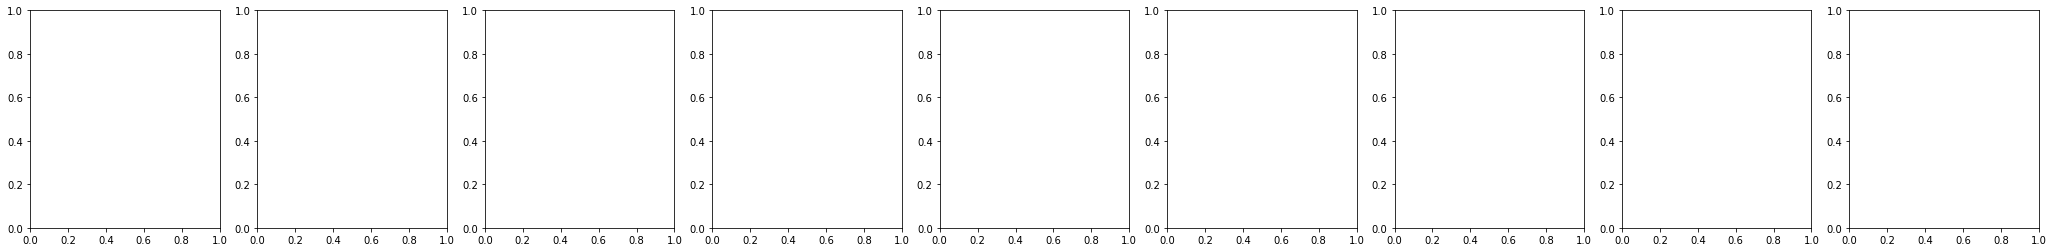

In [ ]:
interp.plot_top_losses(9)

In [ ]:
test_eq(interp.inputs, x)
test_eq(interp.targs, y)
out = learn.model.a * x + learn.model.b
test_eq(interp.preds, out)
test_eq(interp.losses, (out-y)[:,0]**2)

RuntimeError: Expected object of device type cuda but got device type cpu for argument #1 'self' in call to _th_equal

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 03_data.load.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_models.wavenet.ipynb.
Converted 06_models.dnn.ipynb.
Converted 08_metrics.ipynb.
Converted 09_learner.ipynb.
Converted 10_models.nbeats.ipynb.
Converted 20_models.cnn.learner.ipynb.
Converted 21_models.cnn.transforms.ipynb.
Converted index.ipynb.
